In [14]:
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from transformers import get_cosine_schedule_with_warmup
from src.transformations import EqualizeTransform, CenterCrop, Translate
from src.preprocessing import crop_od_fill_if_needed
import pandas as pd
import torch
from pathlib import Path
import matplotlib.pyplot as plt 
from PIL import Image
import cv2

In [47]:
class Args(object):
    def __init__(self):
        self.equalize = "no"

args = Args()
    

In [48]:
equalizer = EqualizeTransform(args)

In [52]:
train_transforms = transforms.Compose([
            equalizer,
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalizing makes it really bady visible with matplotlib
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            Translate(1, 0.20),
            CenterCrop(0.5),
            transforms.Resize((224, 224))
        ])

In [53]:
class ClassifierDataset(Dataset):
    def __init__(self, data_dir, start_idx, end_idx, cache_all=False, transform=None, FACTOR: int = 1.5):
        self.data_dir = data_dir
        self.transform = transform
        self.FACTOR = FACTOR
        self.cache_all = cache_all
        self.data = {}
        labels = pd.read_csv("./data/img_info_extended.csv", index_col=0)
        self.img_info = labels.set_index("new_file").sort_index(ascending=True)
        self.img_info = self.img_info.iloc[start_idx:end_idx, :]
        self.square_filenames = self.img_info.index.to_numpy()
        self.orig_filenames = self.img_info.orig_file.to_numpy()
        self.labels = self.img_info.labels_int.to_numpy()
        self.side = self.img_info.side.to_numpy()
        self.odc_x_square = self.img_info.odc_x_square.to_numpy()
        self.odc_y_square = self.img_info.odc_y_square.to_numpy()
        self.odc_side_pxl = self.img_info.odc_side_pxl.to_numpy()

        if self.cache_all:
            for idx, fn in enumerate(self.orig_filenames):
                filepath = os.path.join(self.data_dir, fn).replace("\\", "/") # replace possibly not necessary
                img = cv2.imread(filepath)  #img = Image.open(filepath).convert('RGB')
                img_data = self.img_info.loc[self.img_info.orig_file == fn]
                odc_x_rect, odc_y_rect = self._get_od_center(img, self.side[idx], self.odc_x_square[idx], self.odc_y_square[idx])
                img = crop_od_fill_if_needed(img, odc_x_rect, odc_y_rect, int(self.odc_side_pxl[idx]*2*self.FACTOR))
                self.data[idx] = img

    def __len__(self):
        return len(self.orig_filenames)

    def _get_od_center(self, img, side, square_x, square_y):
        add_top = (img.shape[0] - side)/2
        add_left = (img.shape[1] - side)/2
        odc_x_rect = int(square_x + add_left)
        odc_y_rect = int(square_y + add_top)
        return odc_x_rect, odc_y_rect

    def _get_data(self, idx):
        cached_val = self.data.get(idx, None)
        if cached_val is not None:
            return cached_val
        else:
            fn = self.orig_filenames[idx]
            filepath = os.path.join(self.data_dir, fn).replace("\\", "/") # replace possibly not necessary
            img = cv2.imread(filepath)  #img = Image.open(filepath).convert('RGB')
            odc_x_rect, odc_y_rect = self._get_od_center(img, self.side[idx], self.odc_x_square[idx], self.odc_y_square[idx])
            img = crop_od_fill_if_needed(img, odc_x_rect, odc_y_rect, int(self.odc_side_pxl[idx]*2*self.FACTOR))
            return img

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self._get_data(idx)

        # apply transforms
        if self.transform:
            img = self.transform(img)

        label = int(self.labels[idx])
        return img, label

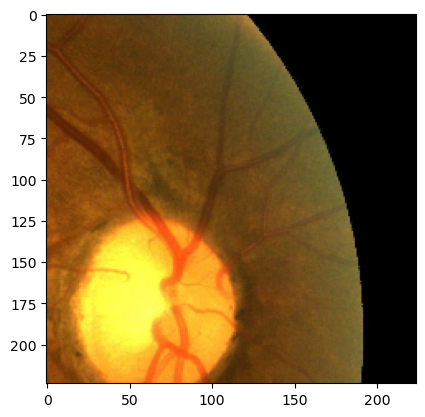

In [54]:
data = ClassifierDataset("data/cfp", start_idx=0, end_idx=8, cache_all = False, transform = train_transforms, FACTOR = 2)
dataloader = DataLoader(data, batch_size=2)
batch = next(iter(dataloader))
plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,[2,1,0]])